# Proyek Pengembangan Machine Learning: Time Series

- Nama: Zakaria Rafi
- Email: zakariarafifahmi@gmail.com
- Id Dicoding:zakaria_rafi

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

In [16]:
# Muat data
df = pd.read_csv('hour.csv')
print(df.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


In [17]:
# Hitung threshold MAE
threshold = (df['cnt'].max() - df['cnt'].min()) * 10 / 100  # Gantikan 'cnt' dengan nama kolom target Anda
print(f"Threshold MAE: {threshold}")

Threshold MAE: 97.6


In [18]:
# Pilih fitur dan target
features = df.drop(columns=["instant", "dteday", "cnt"])
target = df["cnt"]

In [19]:
# Normalisasi fitur
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

In [20]:
# Bagi data menjadi training dan validation sets
X_train, X_val, y_train, y_val = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

In [21]:
# Mencetak jumlah total dataset, jumlah dataset training, dan jumlah dataset validasi
print(f"Total dataset: {len(df)}")
print(f"Training set: {len(X_train)}")
print(f"Validation set: {len(X_val)}")

Total dataset: 17379
Training set: 13903
Validation set: 3476


In [22]:
# Verifikasi apakah validation set sudah sebesar 20% dari total dataset
validation_percentage = len(X_val) / len(df) * 100
print(f"Validation set is {validation_percentage:.2f}% of the total dataset.")

Validation set is 20.00% of the total dataset.


In [23]:
# Ubah bentuk data untuk LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

In [24]:
# Bangun model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], 1), return_sequences=True),
    LSTM(50),
    Dense(1)
])

In [25]:
# Kompilasi model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

In [26]:
# Callback untuk menghentikan training jika MAE < threshold
class ThresholdCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('mae') < threshold and logs.get('val_mae') < threshold:
            print(f"\nMAE dan val_MAE lebih kecil dari threshold pada epoch {epoch}. Menghentikan pelatihan.")
            self.model.stop_training = True

In [27]:
# Latih model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[ThresholdCallback()],  # Tambahkan callback
    verbose=1
)

Epoch 1/100
435/435 [==============================] - 13s 20ms/step - loss: 175.0426 - mae: 175.0426 - val_loss: 162.2791 - val_mae: 162.2791
Epoch 2/100
435/435 [==============================] - 6s 15ms/step - loss: 163.2969 - mae: 163.2969 - val_loss: 152.9660 - val_mae: 152.9660
Epoch 3/100
435/435 [==============================] - 9s 20ms/step - loss: 155.5475 - mae: 155.5475 - val_loss: 146.2402 - val_mae: 146.2402
Epoch 4/100
435/435 [==============================] - 7s 15ms/step - loss: 149.8949 - mae: 149.8949 - val_loss: 141.3985 - val_mae: 141.3985
Epoch 5/100
435/435 [==============================] - 8s 19ms/step - loss: 145.8288 - mae: 145.8288 - val_loss: 138.0943 - val_mae: 138.0943
Epoch 6/100
435/435 [==============================] - 9s 21ms/step - loss: 142.9887 - mae: 142.9887 - val_loss: 136.0009 - val_mae: 136.0009
Epoch 7/100
435/435 [==============================] - 8s 18ms/step - loss: 141.0612 - mae: 141.0612 - val_loss: 134.7298 - val_mae: 134.7298
Epoch

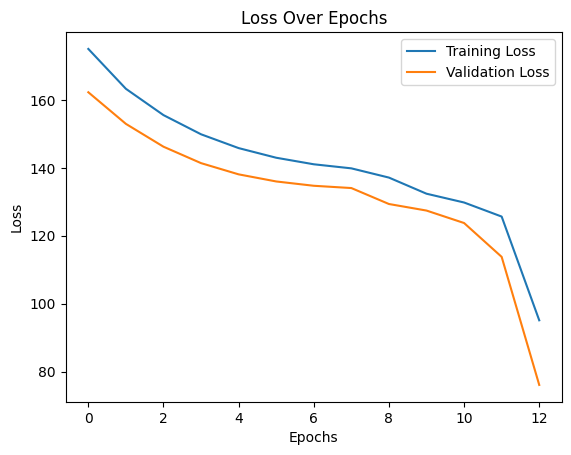

In [28]:
# Plot loss selama training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

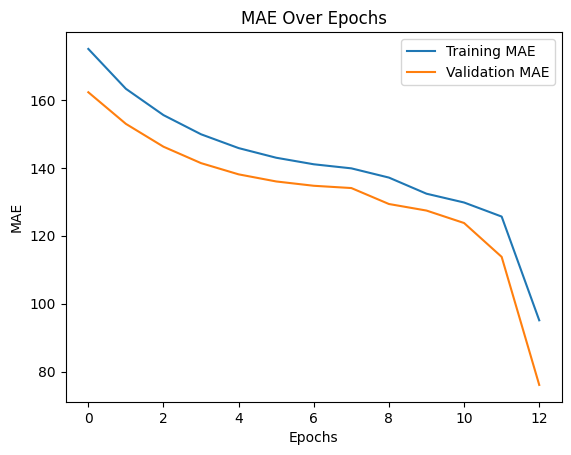

In [29]:
# Tampilkan metrics MAE selama training dan validasi
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()